# Initialize the accelerator

In [1]:
from finn_examples import models
print(list(filter(lambda x: "mnist" in x, dir(models))))

['_mnist_fc_io_shape_dict', 'tfc_w1a1_mnist', 'tfc_w1a2_mnist', 'tfc_w2a2_mnist']


In [2]:
accel = models.tfc_w1a1_mnist()

In [3]:
print("Expected input shape and datatype: %s %s" % (str(accel.ishape_normal), str(accel.idt)))
print("Expected output shape and datatype: %s %s" % (str(accel.oshape_normal), str(accel.odt)))

Expected input shape and datatype: (1, 784) UINT8
Expected output shape and datatype: (1, 1) UINT8


# Load the MNIST dataset

Use the `dataset_loading` package to get easy Python access to MNIST dataset:

In [4]:
from dataset_loading import mnist
trainx, trainy, testx, testy, valx, valy = mnist.load_mnist_data("/tmp", download=True, one_hot=False)

Looking for Train Imgs
Download URL: https://raw.githubusercontent.com/fgnt/mnist/master/train-images-idx3-ubyte.gz
Download DIR: /tmp
>> Downloading train-images-idx3-ubyte.gz 100.1%
Looking for Train Labels
Download URL: https://raw.githubusercontent.com/fgnt/mnist/master/train-labels-idx1-ubyte.gz
Download DIR: /tmp
>> Downloading train-labels-idx1-ubyte.gz 113.5%
Looking for Test Imgs
Download URL: https://raw.githubusercontent.com/fgnt/mnist/master/t10k-images-idx3-ubyte.gz
Download DIR: /tmp
>> Downloading t10k-images-idx3-ubyte.gz 100.4%
Looking for Test Labels
Download URL: https://raw.githubusercontent.com/fgnt/mnist/master/t10k-labels-idx1-ubyte.gz
Download DIR: /tmp
>> Downloading t10k-labels-idx1-ubyte.gz 180.4%


In [ ]:
testx.shape

# Classify a single image

In [20]:
test_single_x = testx[1].reshape(28, 28)
test_single_y = testy[1]

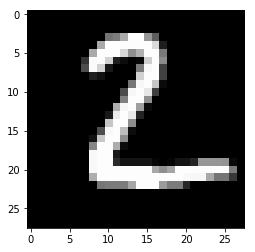

In [21]:
%matplotlib inline
from matplotlib import pyplot as plt

plt.imshow(test_single_x, cmap='gray')
plt.show()

In [22]:
print("Expected class is %d" % test_single_y)

Expected class is 2


In [9]:
accel_in = test_single_x.reshape(accel.ishape_normal)
print("Input buffer shape is %s and datatype is %s" % (str(accel_in.shape), str(accel_in.dtype)))

Input buffer shape is (1, 784) and datatype is uint8


In [10]:
accel_out = accel.execute(accel_in)

In [11]:
print("Returned class is %d" % accel_out)

Returned class is 7


In [12]:
%%timeit
accel_out = accel.execute(accel_in)

1000 loops, best of 3: 1.63 ms per loop


# Validate accuracy on entire MNIST test set

In [13]:
import numpy as np
batch_size = 1000
total = testx.shape[0]
accel.batch_size = batch_size
n_batches = int(total / batch_size)

batch_imgs = testx.reshape(n_batches, batch_size, -1)
batch_labels = testy.reshape(n_batches, batch_size)
obuf_normal = np.empty_like(accel.obuf_packed_device)
print("Ready to run validation, test images tensor has shape %s" % str(batch_imgs.shape))
print("Accelerator buffer shapes are %s for input, %s for output" % (str(accel.ishape_packed), str(accel.oshape_packed)) )

Ready to run validation, test images tensor has shape (10, 1000, 784)
Accelerator buffer shapes are (1000, 1, 784) for input, (1000, 1, 1) for output


In [14]:
ok = 0
nok = 0
for i in range(n_batches):
    ibuf_normal = batch_imgs[i].reshape(accel.ishape_normal)
    exp = batch_labels[i]
    obuf_normal = accel.execute(ibuf_normal)
    ret = np.bincount(obuf_normal.flatten() == exp.flatten())
    nok += ret[0]
    ok += ret[1]
    print("batch %d / %d : total OK %d NOK %d" % (i, n_batches, ok, nok))

batch 0 / 10 : total OK 913 NOK 87
batch 1 / 10 : total OK 1800 NOK 200
batch 2 / 10 : total OK 2714 NOK 286
batch 3 / 10 : total OK 3619 NOK 381
batch 4 / 10 : total OK 4535 NOK 465
batch 5 / 10 : total OK 5488 NOK 512
batch 6 / 10 : total OK 6438 NOK 562
batch 7 / 10 : total OK 7399 NOK 601
batch 8 / 10 : total OK 8371 NOK 629
batch 9 / 10 : total OK 9296 NOK 704


In [15]:
acc = 100.0 * ok / (total)
print("Final accuracy: {}%".format(acc))

Final accuracy: 92.96%


In [16]:
def run_validation():
    for i in range(n_batches):
        ibuf_normal = batch_imgs[i].reshape(accel.ishape_normal)
        exp = batch_labels[i]
        accel.execute(ibuf_normal)

In [17]:
full_validation_time = %timeit -n 5 -o run_validation()

5 loops, best of 3: 72.7 ms per loop


In [18]:
print("%f images per second including data movement" % (total / float(full_validation_time.best)))

137464.318662 images per second including data movement


## Run some more built-in benchmarks

In [19]:
accel.throughput_test()

{'DRAM_in_bandwidth[Mb/s]': 581.3886732673267,
 'DRAM_out_bandwidth[Mb/s]': 0.7415671852899576,
 'batch_size': 1000,
 'copy_input_data_to_device[ms]': 4.782676696777344,
 'copy_output_data_from_device[ms]': 0.17571449279785156,
 'fclk[mhz]': 100.0,
 'fold_input[ms]': 0.14638900756835938,
 'pack_input[ms]': 0.09942054748535156,
 'runtime[ms]': 1.3484954833984375,
 'throughput[images/s]': 741567.1852899576,
 'unfold_output[ms]': 0.18739700317382812,
 'unpack_output[ms]': 0.9598731994628906}